In [1]:
import pyglet
import pyrender
import numpy as np
import trimesh
import trimesh
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
import open3d as o3d
import time
import sys,os

from scipy.spatial import KDTree
from scipy.sparse import diags
from scipy.sparse.linalg import svds

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### 1

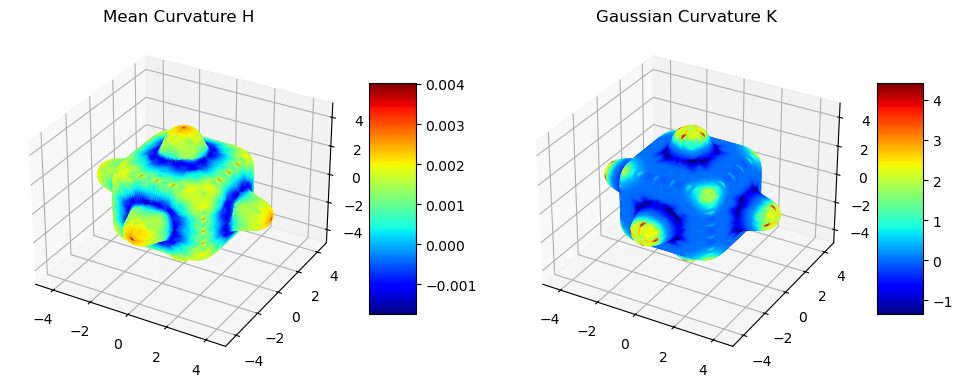

Mean Curvature H: [0.00104645 0.00256149 0.00256149 ... 0.0010222  0.00123956 0.00108484]
Gaussian Curvature K: [ 1.10985307 -0.11453097 -0.11453097 ... -0.51860664 -0.37859726
 -0.61227475]


In [72]:
RES_PATH = 'meshes'
mesh_src = os.path.join(RES_PATH, 'bumpy-cube.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src
from mpl_toolkits.mplot3d import Axes3D

# 使用 trimesh 加载网格
mesh = trimesh.load(mesh_src)
# 获取顶点和面
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)


# 函数计算每个顶点的邻居
def get_vertex_neighbors(faces):
    vertex_neighbors = {}
    for face in faces:
        for i in range(3):
            if face[i] not in vertex_neighbors:
                vertex_neighbors[face[i]] = []
            # 这里将NumPy数组转换为列表进行连接操作,合并当前顶点前面和后面的点
            vertex_neighbors[face[i]].extend(list(face[:i]) + list(face[i+1:]))
            # print(face)
            # print(i, face[i], face[:i], face[i+1:])
    # 删除重复项
    for vertex in vertex_neighbors:
        vertex_neighbors[vertex] = list(set(vertex_neighbors[vertex]))
    return vertex_neighbors

# 计算每个顶点的均质曲率H
def compute_mean_curvature(vertices, vertex_neighbors, normals):
    H = np.zeros(len(vertices))
    for i in range(len(vertices)):
        if i not in vertex_neighbors: continue
        neighbor_vectors = vertices[vertex_neighbors[i]] - vertices[i]
        # print(i, vertex_neighbors[i])
        L = np.sum(neighbor_vectors, axis=0) / len(neighbor_vectors)
        # H[i] = np.linalg.norm(L) / 2
        H[i] = - np.dot(L, normals[i]) / 2
    return H

def triangle_area(vertex1, vertex2, vertex3):
    # 根据三角形三个顶点的坐标计算面积
    # 使用海伦公式，首先计算三边长度
    a = np.linalg.norm(vertex1 - vertex2)
    b = np.linalg.norm(vertex2 - vertex3)
    c = np.linalg.norm(vertex3 - vertex1)
    
    # 计算半周长
    s = (a + b + c) / 2
    
    # 计算面积
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return area

# 肉眼观察法这个应该算对了？
# https://blog.csdn.net/yinhun2012/article/details/112719305
def calculate_triangle_out_circle_center(A, B, C):
    # Convert input lists to NumPy arrays if they aren't already
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)

    # Calculate the vectors representing the sides of the triangle
    AB = B - A
    AC = C - A
    
    # Calculate the normal vector of the plane defined by the triangle
    AN = np.cross(AB, AC)
    AN = AN / np.linalg.norm(AN)  # Normalize the vector

    # Use the normal vector (AN) and point A to define the plane
    d = np.dot(AN, A)

    # Calculate the coefficients of the linear system
    e, f, g = C - A
    h = np.dot(C - A, (C + A) / 2)
    k, l, m = 2 * (B - A)
    n = np.dot(B, B) - np.dot(A, A)

    # Solve the linear system
    A_matrix = np.array([[AN[0], AN[1], AN[2]], [e, f, g], [k, l, m]])
    B_vector = np.array([d, h, n])
    P = np.linalg.solve(A_matrix, B_vector)
    # print(P, A, B, C)
    return P  # Convert the result to list if needed


# Helper function to check if a triangle is obtuse
def is_obtuse_triangle(A, B, C):
    # Check if a triangle is obtuse by comparing the squares of its sides
    a2 = np.linalg.norm(C - B)**2
    b2 = np.linalg.norm(C - A)**2
    c2 = np.linalg.norm(B - A)**2
    return a2 + b2 < c2 or a2 + c2 < b2 or b2 + c2 < a2

# Function to calculate mixed cell Gaussian curvature
def mixed_cells_gaussian_curvature(vertices, faces):
    # Initialize area and angle deficit for each vertex
    voronoi_areas = np.zeros(len(vertices))
    angle_deficits = 2 * np.pi * np.ones(len(vertices))

    # Calculate the Voronoi area and angle deficit for each vertex
    for face in faces:
        A, B, C = vertices[face]
        # Check if the triangle is obtuse
        is_obtuse = is_obtuse_triangle(A, B, C)

        # Compute the circumcenter for non-obtuse triangles
        if not is_obtuse:
            circum_center = calculate_triangle_out_circle_center(A, B, C)

        # Calculate Voronoi area for each vertex in the face
        for i, vertex in enumerate(face):
            opposite_edge = np.delete(face, i)

            if is_obtuse or  circum_center is None:
                # For obtuse triangle, use midpoint of the edge opposite the obtuse angle
                voronoi_areas[vertex] += triangle_area(vertices[vertex], np.mean(vertices[opposite_edge], axis=0), 
                                                       (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
                voronoi_areas[vertex] += triangle_area(vertices[vertex], np.mean(vertices[opposite_edge], axis=0), 
                                                       (vertices[vertex] + vertices[opposite_edge[1]]) / 2)
            else:
                # For non-obtuse triangle, use circumcenter
                voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
                                                       (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
                voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
                                                       (vertices[vertex] + vertices[opposite_edge[1]]) / 2)

            # Compute the angle at vertex
            vec1, vec2 = vertices[opposite_edge[0]] - vertices[vertex], vertices[opposite_edge[1]] - vertices[vertex]
            angle = np.arccos(np.clip(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)), -1, 1))
            angle_deficits[vertex] -= angle

    # Compute Gaussian curvature
    gaussian_curvature = angle_deficits / voronoi_areas
    gaussian_curvature[np.isnan(gaussian_curvature)] = 0  # Handle NaN values

    return gaussian_curvature


# 可视化曲率
def visualize_curvature(vertices, H, K):
    fig = plt.figure(figsize=(12, 6))

    # 可视化均质曲率H
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Mean Curvature H")
    scatter = ax1.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H, cmap='jet')
    fig.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)

    # 可视化高斯曲率K
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Gaussian Curvature K")
    scatter = ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=K, cmap='jet')
    fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=5)

    plt.show()


# 获取每个顶点的邻居3q
vertex_neighbors = get_vertex_neighbors(faces)
# 计算均质曲率H和高斯曲率K
H = compute_mean_curvature(vertices, vertex_neighbors, normals)
K = mixed_cells_gaussian_curvature(vertices, faces)

visualize_curvature(vertices, H, K)
# 输出结果（这里只是打印出来，您可能需要将它们保存到文件或以其他方式处理）
print("Mean Curvature H:", H)
print("Gaussian Curvature K:", K)


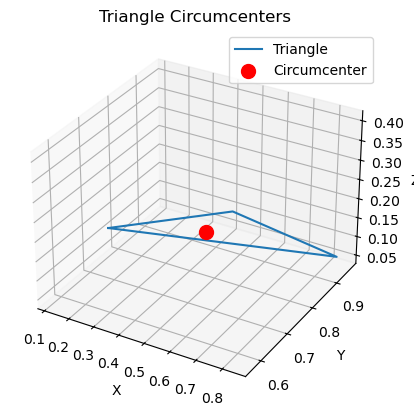

In [110]:
# 检查外心函数到底写得对不对

# 生成随机的三角形
num_triangles = 1
triangles = []
is_obtuse = True
for _ in range(num_triangles):
    while is_obtuse:
        A = np.random.rand(3)  # 随机生成点 A
        B = np.random.rand(3)  # 随机生成点 B
        C = np.random.rand(3)  # 随机生成点 C
        is_obtuse = is_obtuse_triangle(A, B, C)
    triangles.append((A, B, C))

# 计算每个三角形的外心
circumcenters = []
for triangle in triangles:
    circum_center = calculate_triangle_out_circle_center(A, B, C)
    circumcenters.append(circum_center)

# 可视化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for triangle, circumcenter in zip(triangles, circumcenters):
    A, B, C = triangle
    ax.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], [A[2], B[2], C[2], A[2]], label='Triangle')
    ax.scatter(circumcenter[0], circumcenter[1], circumcenter[2], color='red', s=100, label='Circumcenter')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Triangle Circumcenters')
ax.legend()

plt.show()


### 2

In [93]:
# Define the parametric equations of the ellipsoid
def ellipsoid(u, v, a, b, c):
    return np.array([a * np.cos(u) * np.sin(v), b * np.sin(u) * np.sin(v), c * np.cos(v)])

# Calculate the tangent vectors pu and pv
def tangent_vectors(u, v, a, b, c):
    pu = np.array([-a * np.sin(u) * np.sin(v), b * np.cos(u) * np.sin(v), 0])
    pv = np.array([a * np.cos(u) * np.cos(v), b * np.sin(u) * np.cos(v), -c * np.sin(v)])
    return pu, pv

# Calculate the first fundamental form coefficients E, F, G
def first_fundamental_form(u, v, a, b, c):
    pu, pv = tangent_vectors(u, v, a, b, c)
    E = np.dot(pu, pu)
    F = np.dot(pu, pv)
    G = np.dot(pv, pv)
    return E, F, G

# Redefine the second partial derivatives to avoid the singularity at v = 0
def second_partials_corrected(u, v, a, b, c):
    puu = np.array([-a * np.cos(u) * np.sin(v), -b * np.sin(u) * np.sin(v), 0])
    puv = np.array([-a * np.sin(u) * np.cos(v), b * np.cos(u) * np.cos(v), 0])  # Avoid division by sin(v) when v=0
    pvv = np.array([a * np.cos(u) * np.cos(v), b * np.sin(u) * np.cos(v), -c * np.sin(v)])
    return puu, puv, pvv

# Recalculate unit normal vector N to handle the case when cross product is zero
def unit_normal_corrected(u, v, a, b, c):
    pu, pv = tangent_vectors(u, v, a, b, c)
    normal = np.cross(pu, pv)
    norm = np.linalg.norm(normal)
    return normal if norm == 0 else normal / norm

# Recalculate the second fundamental form coefficients L, M, N using the corrected second partials
def second_fundamental_form_corrected(u, v, a, b, c):
    puu, puv, pvv = second_partials_corrected(u, v, a, b, c)
    norm = unit_normal_corrected(u, v, a, b, c)
    L = np.dot(puu, norm)
    M = np.dot(puv, norm)
    N = np.dot(pvv, norm)
    return L, M, N

# Update the normal curvature function to use the corrected forms and handle direction correctly
def normal_curvature_corrected(u, v, a, b, c, direction):
    E, F, G = first_fundamental_form(u, v, a, b, c)
    L, M, N = second_fundamental_form_corrected(u, v, a, b, c)
    direction = np.array(direction)
    direction = direction / np.linalg.norm(direction)  # Normalize the direction vector
    l = np.dot(direction, tangent_vectors(u, v, a, b, c)[0])
    m = np.dot(direction, tangent_vectors(u, v, a, b, c)[1])
    # Check if the denominator is zero to avoid division by zero
    denominator = E*l**2 + 2*F*l*m + G*m**2
    if denominator == 0:
        return float('inf')  # The curvature is infinite if the denominator is zero
    else:
        # Curvature formula
        kn = (L*l**2 + 2*M*l*m + N*m**2) / denominator
        return kn

# Example usage
a, b, c = 1, 2, 3  # Semi-axes of the ellipsoid
u, v = np.pi/2, 0  # At the point (a, 0, 0)
# Use the corrected function to calculate the normal curvature
# Now we also use a three-dimensional direction vector
direction = [1, 0, 0]  # This direction vector is already in the tangent plane at (a, 0, 0)

# Calculate normal curvature at (a, 0, 0) in the given direction using the corrected functions
kn_at_a00 = normal_curvature_corrected(u, v, a, b, c, direction)
kn_at_a00


0.0

In [113]:
import numpy as np

# Function to compute the first and second fundamental forms
# 检查过了理解了
def fundamental_forms(a, b, c, u, v):
    # First, we define the parametric surface function for the ellipsoid
    def ellipsoid(u, v):
        return np.array([a * np.cos(u) * np.sin(v), 
                         b * np.sin(u) * np.sin(v), 
                         c * np.cos(v)])
    
    # Compute the partial derivatives for the tangent vectors
    def partial_u(u, v):
        return np.array([-a * np.sin(u) * np.sin(v), 
                          b * np.cos(u) * np.sin(v), 
                          0])
    
    def partial_v(u, v):
        return np.array([a * np.cos(u) * np.cos(v), 
                         b * np.sin(u) * np.cos(v), 
                        -c * np.sin(v)])
    
    # Compute the normal vector by taking the cross product of the partial derivatives
    def normal_vector(u, v):
        return np.cross(partial_u(u, v), partial_v(u, v))
    
    # Normalize the normal vector
    def unit_normal(u, v):
        n = normal_vector(u, v)
        return n / np.linalg.norm(n)
    
    # Compute the second derivatives
    def second_partial_uu(u, v):
        return np.array([-a * np.cos(u) * np.sin(v), 
                         -b * np.sin(u) * np.sin(v), 
                          0])
    
    def second_partial_uv(u, v):
        return np.array([-a * np.sin(u) * np.cos(v), 
                          b * np.cos(u) * np.cos(v), 
                         c * np.sin(v)])
    
    def second_partial_vv(u, v):
        return np.array([-a * np.cos(u) * np.sin(v), 
                         -b * np.sin(u) * np.sin(v), 
                         -c * np.cos(v)])
    
    # Compute the coefficients of the first fundamental form
    E = np.dot(partial_u(u, v), partial_u(u, v))
    F = np.dot(partial_u(u, v), partial_v(u, v))
    G = np.dot(partial_v(u, v), partial_v(u, v))
    
    # Compute the coefficients of the second fundamental form
    L = np.dot(second_partial_uu(u, v), unit_normal(u, v))
    M = np.dot(second_partial_uv(u, v), unit_normal(u, v))
    N = np.dot(second_partial_vv(u, v), unit_normal(u, v))
    
    return (E, F, G), (L, M, N)

# 还是不理解这里的du和dv是啥意思，为啥这么取
# Function to compute the normal curvature
def normal_curvature(a, b, c, direction_vector):
    # At the point (a,0,0), u = 0 and v = pi/2
    u = np.pi
    v = np.pi / 2
    
    # Compute the first and second fundamental forms at (a,0,0)
    (E, F, G), (L, M, N) = fundamental_forms(a, b, c, u, v)
    
    # Compute the normal curvature using the formula
    # k_n = (Ldu^2 + 2Mdu*dv + Ndv^2) / (Edu^2 + 2Fdu*dv + Gdv^2)
    # For direction vector (du, dv), normalize it first
    # 在该点的局部切平面上的方向向量 (du,dv)。由于这个点在椭球的赤道上，我们可以简单地取 du 和 dv 来代表赤道方向和极点方向
    du, dv = direction_vector
    magnitude = np.sqrt(du**2 + dv**2)
    du, dv = du / magnitude, dv / magnitude
    
    numerator = L*du**2 + 2*M*du*dv + N*dv**2
    denominator = E*du**2 + 2*F*du*dv + G*dv**2
    k_n = numerator / denominator
    
    return k_n

# Let's define the semi-axes of the ellipsoid and the direction vector
a, b, c = 1, 2, 3  # For example, a ellipsoid
direction_vector = (1, 0)  # Example direction, could be any vector on the tangent plane

# Compute the normal curvature at (a,0,0) in the given direction
k_n = normal_curvature(a, b, c, direction_vector)
k_n


0.25

### 3